<a href="https://colab.research.google.com/github/MosaabMuhammed/Image-Search-Engine/blob/main/Deep_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Autoencoders

Autoencoders are trained on encoding input data such as images into a smaller feture vector, and afterward, reconstruct it by a second nural network, called a decoder.

The feature vector is called the "bottleneck" of the network as we aim to compress the input data into a smaller amount of features.

This property is useful in many applications, in particular in compressing data or comparing images on a metric beyond pixel-level comprsion.

## Imports

In [ ]:
import os
import json
import math
import numpy as np

## Imports for plotting
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import set_matplotlib_formats
set_matplotlib_formats("svg", "pdf") # For exports
from matplotlib.colors import to_rgb
import matplotlib
matplotlib.rcParams['lines.linewidth'] = 2.0
import seaborn as sns
sns.reset_orig()
sns.set()

## Progress bar
from tqdm.notebook import tqdm

## PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.utils.data as data
import torch.optim as optim

## Torchvision
import torchvision
from torchvision.datasets import CIFAR10
from torchvision import transforms

# PyTorch Lightning
try:
    import pytorch_lightning as pl
except ModuleNotFoundError:
    !pip install --quiet pytorch-lightning>=1.4
    import pytorch_lightning as pl
from pytorch_lightning.callbacks import LearningRateMonitor, ModelCheckpoint

# Tensorboard extension (for visualization purposes later)
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

# Path to the folder where the datasets are/should be saved.
DATASET_PATH = "/content/data"
CHECKPOINT_PATH = "/content/checkpoints"

# Setting the seed
pl.seed_everything(42)

# Ensure that all operations are deterministic on GPU (if used) for reproducibility
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = torch.device("cuda:0") if torch.cuda.is_available() else torch.device("cpu")
print(f"Device: {device}")

<ipython-input-1-654817eddd63>:10: DeprecationWarning: `set_matplotlib_formats` is deprecated since IPython 7.23, directly use `matplotlib_inline.backend_inline.set_matplotlib_formats()`
  set_matplotlib_formats("svg", "pdf") # For exports
INFO:lightning_fabric.utilities.seed:Global seed set to 42


Device: cpu


## Dataset

In this project, I will be using CIFAR10 dataset. In CIFAR10, each image has 3 color channels and is 32x32 pixels large.

As Autoencoders do not have the constrain of modeling images probabilistic, we can work on more complex image data (i.e. 3 color channels instead of black-and-white) much easier than for VAEs.

We will normalize our dataset between -1 and 1, this is because limiting the range will make our task of predicting/reconstructing images easier.

In [ ]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Loading the training dataset, we need to split it into a training and validation sets.
train_dataset = CIFAR10(root=DATASET_PATH,
                        train=True,
                        transform=transform,
                        download=True)
pl.seed_everything(42)

train_set, valid_set = torch.utils.data.random_split(train_dataset, [45_000, 5000])

# Loading the testing dataset
test_set = CIFAR10(root=DATASET_PATH,
                       train=False,
                       transform=transform,
                       download=True)

# We define a set of dataloaders that we can use for various purposes later.
train_loader = data.DataLoader(train_set,
                               batch_size=256,
                               shuffle=True,
                               drop_last=True,
                               pin_memory=True,
                               num_workers=4)
valid_loader = data.DataLoader(valid_set,
                               batch_size=256,
                               shuffle=False,
                               drop_last=False,
                               num_workers=4)
test_loader = data.DataLoader(test_set,
                              batch_size=256,
                              shuffle=False,
                              drop_last=False,
                              num_workers=4)

def get_train_images(num):
    return torch.stack([train_dataset[i][0] for i in range(num)], dim=0)

Files already downloaded and verified


INFO:lightning_fabric.utilities.seed:Global seed set to 42


Files already downloaded and verified


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


## Autoencoder

In general, an autoencoder consists of an `encoder` that maps the input `x` to a lower-dimensional features vector `z`, and a `decoder` that reconstructs the input `x_hat` and optimize the parameters to increase the similarity between `x` and `x_hat`.

I first start by implementing the encoder. The encoder effectively consists of a deep convolutional network, where we scale down the image layer-by-layer using strided convolutions. After downscaling the image 3 times, we flatten the features and apply linear layers.

The latent representation `z` is therefore a vector of size `d` which can be flexibly selected.

In [ ]:
class Encoder(nn.Module):

    def __init__(self,
                 num_input_channels: int,
                 base_channel_size: int,
                 latent_dim: int,
                 act_fn: object = nn.GELU):
        """
        Inputs:
            - num_input_channels: Number of input channels of the image. For CIFAR this parameter is 3.
            - base_channel_size: Number of channels we use in the first Convolutional layers. Deeper layers might use a duplicate of it.
            - latent_dim: Dimensionality of latent represetnation z
            - act_fn: Activation function used throughout the encoder network.
        """
        super().__init__()
        c_hid = base_channel_size

        self.net = nn.Sequential(
            nn.Conv2d(num_input_channels, c_hid, kernel_size=3, padding=1, stride=2), # 32x32 => 16x16
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),

            nn.Conv2d(c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 16x16 => 8x8
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),

            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1, stride=2), # 8x8 => 4x4
            act_fn(),

            nn.Flatten(),
            nn.Linear(2*c_hid*4*4, latent_dim)
        )

    def forward(self, x):
        out = self.net(x)
        return out


In [ ]:
model = Encoder(num_input_channels=3,
                base_channel_size=128,
                latent_dim=32)

x = torch.rand((1, 3, 28, 28))
out = model(x)


NOTE:

I don't apply Batch Normalization here, this is because I want the encoding of each image to be independent of all the other images.

## Decoder

The decoder is mirrored, flipped version of the encoder. The only difference is that we replace strided convolutions by transposed convolutions (i.e. deconvolutions) to upscale the features.

In [ ]:
class Decoder(nn.Module):

    def __init__(self,
                 num_input_channels: int,
                 base_channel_size: int,
                 latent_dim: int,
                 act_fn: object = nn.GELU):
        """
        Inputs:
            - num_input_channels: Number of channels of the image to reconstruct. For CIFAR10, this parameter is 3.
            - base_channel_size: Number of channels we use in the last convolutional layers.
            - latent_dim: Dimensionality of latent representation z.
            - act_fn: Activation function used throughout the decoder network.
        """

        super().__init__()
        c_hid = base_channel_size

        self.linear = nn.Sequential(
            nn.Linear(latent_dim, 2*c_hid*4*4),
            act_fn()
        )

        self.net = nn.Sequential(
            nn.ConvTranspose2d(2*c_hid, 2*c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(2*c_hid, 2*c_hid, kernel_size=3, padding=1),
            act_fn(),

            nn.ConvTranspose2d(2*c_hid, c_hid, kernel_size=3, output_padding=1, padding=1, stride=2),
            act_fn(),
            nn.Conv2d(c_hid, c_hid, kernel_size=3, padding=1),
            act_fn(),

            nn.ConvTranspose2d(c_hid, num_input_channels, kernel_size=3, output_padding=1, padding=1, stride=2),
            nn.Tanh() # The input images is scaled between -1 and 1, hence the output has to be bounded as well.
        )

    def forward(self, x):
        x = self.linear(x)
        x = x.reshape(x.shape[0], -1, 4, 4)
        x = self.net(x)
        return x

In [ ]:
model = Decoder(num_input_channels=3,
                base_channel_size=128,
                latent_dim=32)

x = torch.rand((1, 32))
out = model(x)
print(out.shape)

torch.Size([1, 3, 32, 32])


The encoder and decoder networks we chose here are relatively simple. Usually, more complex networks are applied, especially when using a ResNet-based architecture.

## Autoencoder

In [ ]:
class Autoencoder(pl.LightningModule):

    def __init__(self,
                 base_channel_size: int,
                 latent_dim: int,
                 encoder_class: object = Encoder,
                 decoder_class: object = Decoder,
                 num_input_channels: int = 3,
                 width: int = 32,
                 height: int = 32):
        super().__init__()

        self.save_hyperparameters()

        # Creating encoder and decoder
        self.encoder = encoder_class(num_input_channels, base_channel_size, latent_dim)
        self.decoder = decoder_class(num_input_channels, base_channel_size, latent_dim)

        self.example_input_array = torch.zeros(2, num_input_channels, width, height) # needed for visualization

    def forward(self, x):
        z = self.encoder(x)
        x_hat = self.decoder(z)
        return x_hat

    def _get_reconstruction_loss(self, batch):
        """
        Given a batch of images, this function returns the reconstruction loss (MSE in our case)
        """
        x, _ = batch
        x_hat = self.forward(x)
        loss = F.mse_loss(x, x_hat, reduction="none")
        loss = loss.sum(dim=[1, 2, 3]).mean(dim=[0])
        return loss

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs.
        scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,
                                                         mode="min",
                                                         factor=0.2,
                                                         patience=20,
                                                         min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "valid loss"}

    def training_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('train_loss', loss)
        return loss

    def validation_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('valid loss', loss)
        return loss

    def test_step(self, batch, batch_idx):
        loss = self._get_reconstruction_loss(batch)
        self.log('test_loss', loss)
        return loss


## MSE Loss

For the loss function, we use the mean squared error (MSE). The mean squared error pushes the network to pay special attention to those pixel values its estimate is far away. Predicting 127 instead of 128 is not important when reconstructing, but confusing 0 with 128 is much worse.

Note that in contrast to VAEs, we do not predict the probability per
pixel value, but instead use a distance measure. This saves a lot of parameters and simplifies training. To get a better intuition per pixel, we report the summed squared error averaged over the batch dimension (any other mean/sum leads
to the same result/parameters).

However, MSE has also some considerable disadvantages. Usually, MSE leads to blurry images where small noise/high-frequent patterns are removed as those cause a very low error.

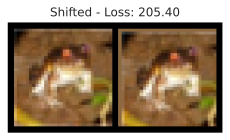

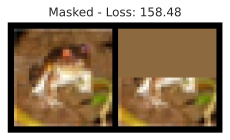

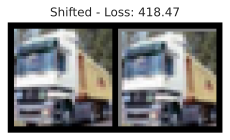

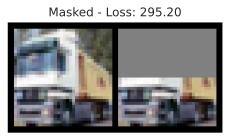

In [ ]:
def compare_imgs(img1, img2, title_prefix=""):
    # Calculate MSE loss between both images
    loss = F.mse_loss(img1, img2, reduction="sum")

    # Plot images for visual comparsion
    grid = torchvision.utils.make_grid(torch.stack([img1, img2], dim=0), nrow=2, normalize=True, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(4, 2))
    plt.title(f"{title_prefix} Loss: {loss.item():4.2f}")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

for i in range(2):
    # Load example image
    img, _ = train_dataset[i]
    img_mean = img.mean(dim=[1, 2], keepdims=True)

    # Shift image by one pixel
    SHIFT = 1
    img_shifted = torch.roll(img, shifts=SHIFT, dims=1)
    img_shifted = torch.roll(img_shifted, shifts=SHIFT, dims=2)
    img_shifted[:, :1, :] = img_mean
    img_shifted[:, :, :1] = img_mean
    compare_imgs(img, img_shifted, "Shifted -")

    # Set half of the image to zero
    img_masked = img.clone()
    img_masked[:, :img_masked.shape[1]//2, :] = img_mean
    compare_imgs(img, img_masked, "Masked -")

# Training the model

During the training, we want to keep track of the learning progress by seeing reconstructions made by our model.


For this, we implement a callback object in PyTorch Lightning which will add reconstructions every N epochs to our tensorboard:

In [ ]:
class GenerateCallback(pl.Callback):

    def __init__(self, input_imgs, every_n_epochs):
        self.input_imgs = input_imgs
        self.every_n_epochs = every_n_epochs

    def on_train_epoch_end(self, trainer, pl_module):
        if trainer.current_epoch % self.every_n_epochs == 0:
            input_imgs = self.input_imgs.to(pl_module.device)
            with torch.inference_mode():
                pl_module.eval()
                reconst_imgs = pl_module(input_imgs)
                pl_module.train()

            imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
            grid = torchvision.utils.make_grid(imgs, nrow=2, normalize=True, range=(-1, 1))
            trainer.logger.experiment.add_image("Reconstructions", grid, global_step=trainer.global_step)

We will now write a training function that allows us to train the autoencoder with different latent dimensionality and returns both the test and validation score. We provide pre-trained models and recommend you using those, especially when you work on a computer without GPU.

In [ ]:
def train_cifar(latent_dim):
    # Create a PyTorch Lightning trainer with the generation callback
    trainer = pl.Trainer(default_root_dir=os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}"),
                         accelerator="gpu" if str(device).startswith("cuda") else "cpu",
                         devices=1,
                         max_epochs=500,
                         callbacks=[ModelCheckpoint(save_weights_only=True),
                                    GenerateCallback(get_train_images(8), every_n_epochs=10),
                                    LearningRateMonitor("epoch")])
    trainer.logger._log_graph = True
    trainer.logger._default_hp_metric = None

    pretrained_filename = os.path.join(CHECKPOINT_PATH, f"cifar10_{latent_dim}.ckpt")
    if os.path.isfile(pretrained_filename):
        print("Found pretrained model, loading...")
        model = Autoencoder.load_from_checkpoint(pretrained_filename)
    else:
        model = Autoencoder(base_channel_size=32, latent_dim=latent_dim)
        trainer.fit(model, train_loader, valid_loader)

        # Test best model on validation and test set
        valid_result = trainer.test(model, valid_loader, verbose=False)
        test_result  = trainer.test(model, test_loader, verbose=False)
        result = {"test": test_result, "valid": valid_result}
        return model, result

In [ ]:
model_dict = {}
for latent_dim in [64, 128, 256, 384]:
    model_ld, result_ld = train_cifar(latent_dim)
    model_dict[latent_dim] = {"model": model_ld, "result": result_ld}

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name    | Type    | Params | In sizes       | Out sizes     
----------------------------------------------------------------------
0 | encoder | Encoder | 168 K  | [2, 3, 32, 32] | [2, 64]       
1 | decoder | Decoder | 168 K  | [2, 64]        | [2, 3, 32, 32]
----------------------------------------------------------------------
337 K     Trainable params
0         Non-trainable params
337 K     Total params
1.348     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:560: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

After training the models, we can plot the reconstruction loss over the latent dimensionanlity to get an intuition how these 2 properties are correlated

In [ ]:
latent_dims = sorted([k for k in model_dict])
val_scores = [model_dict[k]['result']['val'][0]['test_loss'] for k in latent_dim]

fig = plt.figure(figsize=(6, 4))
plt.plot(latent_dims, val_scores, '--', color="#000", marker="*", markeredgecolor="#000", markerfacecolor="y", markersize=16)
plt.xscale("log")
plt.xticks(latent_dims, labels=latent_dims)
plt.title("Reconstruction error over latent dimensionality", fontsize=14)
plt.xlabel("Latent dimensionality")
plt.ylabel("Reconstruction error")
plt.minorticks_off()
plt.ylim(0, 100)
plt.show()

As we initially expected, the reconstruction loss goes down with increasing latent dimensionality. For our model and setup, the two properties seem to be exponentially (or double exponentially) correlated.

To understand what these differences in reconstruction error mean, we can visualize example reconstructions of the four models. For simplicity, we visualize four training images of CIFAR10 we have seen already before. For larger models that may overfit, it is recommended to use images from the validation set.

In [ ]:
def visualize_reconstruction(model, input_imgs):
    # Reconstruction images
    model.eval()
    with torch.inference_mode():
        reconst_imgs = model(input_imgs.to(model.device))
    reconst_imgs = reconst_imgs.cpu()

    # Plotting
    imgs = torch.stack([input_imgs, reconst_imgs], dim=1).flatten(0, 1)
    grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(7, 4.5))
    plt.title(f"Reconstructed from {model.hparams.latent_dim} latents")
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
input_imgs = get_train_images(4)

for latent_dim in model_dict:
    visualize_reconstruction(model_dict[latent_dim]['model'], input_imgs)

Clearly the smallest latent dimensionality can only save information about the rough shape and color of the object, but the reconstructed image is extremely blurry and it's hard to recognize the original object in the reconstruction.

With 128 features, we can recognize some shapes again although the picture remains blurry. The models with the highest 2 dimensionalities reconstrcut the images quite well.

The difference between 256 and 384 is marginal at first sight but can be noticed when comparing, for instance, the backgrounds of the first image (the 384 features model more of the pattern than 256 image).

# Out-of-distribution Images

Now we can explore some limitations of our autoencoder.

First experiment is we try to reconstruct noise. We, therefore, create two images whose picels are randomly sampled from a uniform distribution over pixel values, and visualize the reconstruction of the model.

In [ ]:
rand_imgs = torch.rand(2, 3, 32, 32) * 2 - 1
visualize_reconstructions(model_dict[256]["model"], rand_imgs)

The reconstruction of the noise is quite poor, and seems to introduce some rough patterns. As the input doesn't follow the patterns of the CIFAR dataset, the model has issues reconstructing it accurately.

We can also check how well the model can reconstruct other manually-coded patterns:

In [ ]:
plain_imgs = torch.zeros(4, 3, 32, 32)

# Single color image
plain_imgs[1, 0] = 1  # Red image

# Checkboard pattern
plain_imgs[2, :, :16, :16] = 1
plain_imgs[2, :, 16:, 16:] = -1

# Color progression
xx, yy = torch.meshgrid(torch.linspace(-1, 1, 32), torch.linspace(-1, 1, 32))
plain_imgs[3, 0, :, :] = xx
plain_imgs[3, 1, :, :] = yy

visualize_reconstructions(model_dict[256]['model'], plain_imgs)

The plain, constant images are reconstructed relatively good although the single color channel contains some noticeable noise. The hard borders of the checkboard pattern are not as sharp as intended, as well as the color progression, both because such patterns never occur in the real-world pictures of CIFAR.

## Generating New Images

Variational autoencoders are a generative version of the autoencoders because we regularize the latent space to follow a Gaussian distribution. However, in vanilla autoencoders, we do not have any restrictions on the latent vector. So what happens if we would actually input a randomly sampled latent vector into the decoder? Let’s find it out below:

In [ ]:
model = model_dict[256]["model"]

latent_vectors = torch.randn(8, model.hparams.latent_dim, device=model.device)

with torch.inference_mode():
    imgs = model.decoder(latent_vectors)
    imgs = imgs.cpu()

grid = torchvision.utils.make_grid(imgs, nrow=4, normalize=True, range=(-1, 1), pad_value=0.5)
grid = grid.permute(1, 2, 0)
plt.figure(figsize=(8, 5))
plt.imshow(grid)
plt.axis('off')
plt.show()

As we can see, the generated images more look like art than realistic images. As the autoencoder was allowed to structure the latent space in whichever way it suits the reconstruction best, there is no incentive to map every possible latent vector to realistic images. Furthermore, the distribution in latent space is unknown to us and doesn’t necessarily follow a multivariate normal distribution. Thus, we can conclude that vanilla autoencoders are indeed not generative.

### Finding Visually Similar Images

One application of autoencoders is to build an image-based search engine to retrieve visually similar images. This can be done by represeting all images as their latent dimensionality, and find the closest K images in this domain. The first step to such a search engine is to encode all images into z.

In the following, we will use the training  set as a search corpus, and the test set as queries to the system.

In [ ]:
model = model_dict[128]["model"]

In [ ]:
def embed_imgs(model, data_loader):
    # Encode all images in the data_loader using model, and return both images and encodings.
    img_list, embed_list = [], []
    model.eval()
    for imgs, _ in tqdm(data_loader, desc="Encoding Images", leave=False):
        with torch.inference_mode():
            z = model.encoder(imgs.to(model.device))
        img_list.append(imgs)
        embed_list.append(z)

    return (torch.cat(img_list, dim=0), torch.cat(embed_list, dim=0))

train_img_embeds = embed_imgs(model, train_loader)
test_img_embeds  = embed_imgs(model, test_loader)

After encoding all images, we just need to write a function that finds the closest K images and returns (or plots) those:

In [ ]:
def find_similar_images(query_img, query_z, key_embeds, K=8):
    # Find closest K images. we use euclidean distance here but other like cosine distance can be used too.
    dist = torch.cdist(query_z[None, :], key_embeds[1], p=2)
    dist = dist.squeeze(dim=0)
    dist, indices = torch.sort(dist)

    imgs_to_display = torch.cat([query_img[None], key_embeds[0][indices[:K]]], dim=0)
    grid = torchvision.utils.make_grid(imgs_to_display, nrows=K+1, normalize=True, range=(-1, 1))
    grid = grid.permute(1, 2, 0)
    plt.figure(figsize=(12, 3))
    plt.imshow(grid)
    plt.axis('off')
    plt.show()

In [ ]:
# Plot the closest images for the first N test images as example
for i in range(8):
    find_similar_images(test_img_embeds[0][i], test_img_embeds[1][i], key_embeds=train_img_embeds)

Based on our autoencoder, we see that we are able to retrieve many similar images to the test input.

In particular, in row 4, we can spot that some test images might not be that different from the training set as we thought (same poster, just different scaling/color scaling).

We also see that although we haven’t given the model any labels, it can cluster different classes in different parts of the latent space (airplane + ship, animals, etc.).

This is why autoencoders can also be used as a pre-training strategy for deep networks, especially when we have a large set of unlabeled images (often the case).

However, it should be noted that the background still plays a big role in autoencoders while it doesn’t for classification. Hence, we don’t get “perfect” clusters and need to finetune such models for classification.